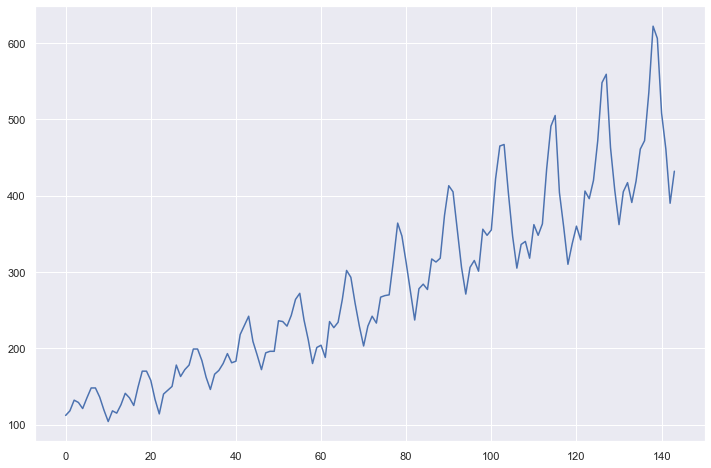

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 1 to 143
Data columns (total 2 columns):
var1(t-1)    143 non-null float64
var1(t)      143 non-null float64
dtypes: float64(2)
memory usage: 3.4 KB
train_x:(85, 1, 1)
train_y:(85,)
valid_x:(28, 1, 1)
valid_y:(28,)
test_x:(30, 1, 1)
test_y:(30,)


In [260]:
import tensorflow as tf
import keras
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
mpl.rcParams['figure.figsize']=12,8
sns.set()

data = pd.read_csv('international-airline-passengers.csv')
columns=['date','data']
data.columns=columns
data.head()

data.tail()

len(data)

plt.plot(data[:]['data'])
plt.show()

def series_to_supervised(data, n_in=1, n_out=1, dropna=True):
    '''
    	data: origin data
    	n_in: 
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(),list()
    
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
        names+=[('var%d(t-%d)'%(j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i==0:
            names += [('var%d(t)'%(j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)'%(j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropna: # 是否去除缺失值的行
        agg.dropna(inplace=True)
    return agg

data.head()

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['data'].values.reshape(-1,1))
scaled_data

reframed = series_to_supervised(scaled_data, 1, 1)
reframed.head(),reframed.info()

train_ratio = 0.6
valid_ratio = 0.2
test_ratio = 0.2
train_days = int(train_ratio*len(reframed))
valid_days = int(valid_ratio*len(reframed))

def data_split(reframed_data, train_ratio=0.6, valid_ratio=0.2):
    train_days = int(train_ratio*len(reframed_data))
    valid_days = int(valid_ratio*len(reframed_data))
    values = reframed_data.values
    train = values[:train_days]
    valid = values[train_days:train_days+valid_days]
    test = values[train_days+valid_days:]
    return train,valid,test


train,valid,test = data_split(reframed, 0.6, 0.2)

def data_to_lstm(train, valid, test, timesteps=1, val_dim=1):
    train_x, train_y = train[:,:-1], train[:,-1]
    valid_x, valid_y = valid[:,:-1], valid[:,-1]
    test_x, test_y = test[:,:-1], test[:,-1]
    train_x = train_x.reshape((train_x.shape[0],timesteps,val_dim))
    valid_x = valid_x.reshape((valid_x.shape[0],timesteps,val_dim))
    test_x = test_x.reshape((test_x.shape[0],timesteps,val_dim))
    print('train_x:{0}'.format(train_x.shape))
    print('train_y:{0}'.format(train_y.shape))
    print('valid_x:{0}'.format(valid_x.shape))
    print('valid_y:{0}'.format(valid_y.shape))
    print('test_x:{0}'.format(test_x.shape))
    print('test_y:{0}'.format(test_y.shape))
    return train_x,train_y,valid_x,valid_y,test_x,test_y

train_x,train_y,valid_x,valid_y,test_x,test_y=data_to_lstm(train,valid,test,1,1)



## 搭模型+训练

In [254]:
# exp_loss =[]
# exp_acc = []

model = keras.Sequential([
    keras.layers.LSTM(8, activation='relu', input_shape=(train_x.shape[1],train_x.shape[2])),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])
model.summary()

# for i in range(1,5):
model_history = model.fit(train_x,train_y,
                         epochs=80,
                         batch_size=1,
                         validation_data=(valid_x,valid_y),
                         verbose=2,
                         shuffle=False)

# plt.figure(figsize=(8,6))
# plt.plot(model_history.epoch, model_history.history['loss'], c='b', label='loss')
# plt.plot(model_history.epoch, model_history.history['val_loss'], c='r', label='val_loss')
# plt.legend()
# plt.show()

evaluate_res = model.evaluate(test_x,test_y)
print(evaluate_res)
#     exp_loss.append(evaluate_res[0])
#     exp_acc.append(evaluate_res[1])

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 8)                 320       
_________________________________________________________________
dense_46 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 5         
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________
Train on 85 samples, validate on 28 samples
Epoch 1/80
 - 1s - loss: 0.0143 - accuracy: 0.0118 - val_loss: 0.0807 - val_accuracy: 0.0000e+00
Epoch 2/80
 - 0s - loss: 0.0106 - accuracy: 0.0118 - val_loss: 0.0624 - val_accuracy: 0.0000e+00
Epoch 3/80
 - 0s - loss: 0.0114 - accuracy: 0.0118 - val_loss: 0.0578 - val_accuracy: 0.0000e+00
Epoch 4/80
 - 0s - loss: 0.0111 - accuracy: 0.0118

Epoch 77/80
 - 0s - loss: 0.0018 - accuracy: 0.0118 - val_loss: 0.0058 - val_accuracy: 0.0000e+00
Epoch 78/80
 - 0s - loss: 0.0018 - accuracy: 0.0118 - val_loss: 0.0058 - val_accuracy: 0.0000e+00
Epoch 79/80
 - 0s - loss: 0.0018 - accuracy: 0.0118 - val_loss: 0.0058 - val_accuracy: 0.0000e+00
Epoch 80/80
 - 0s - loss: 0.0018 - accuracy: 0.0118 - val_loss: 0.0058 - val_accuracy: 0.0000e+00
30/30 [==============================] - 0s 67us/step
[0.012938454747200012, 0.03333333507180214]


## 标准化数据绘图

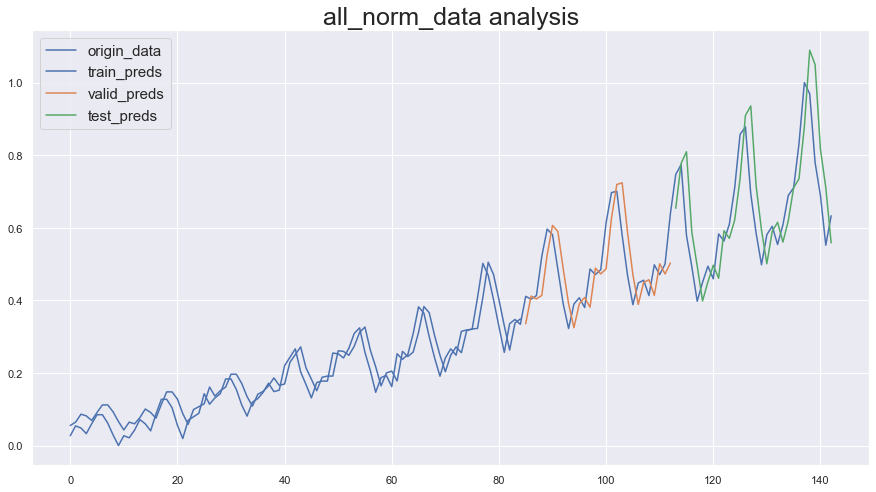

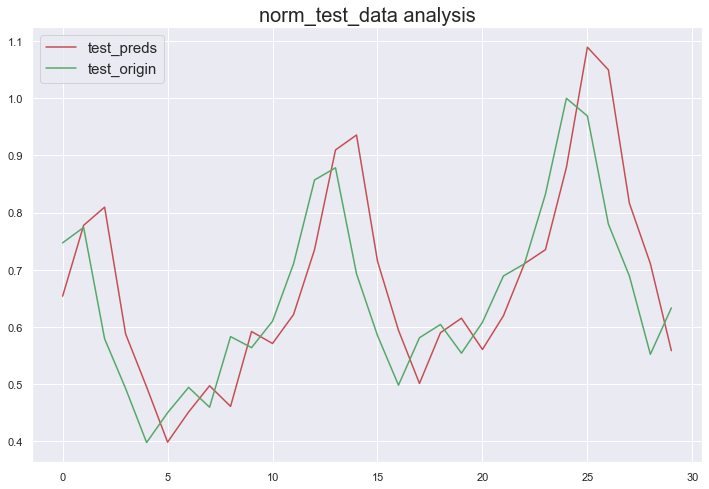

In [256]:

test_preds = model.predict(test_x)
train_preds = model.predict(train_x)
valid_preds = model.predict(valid_x)

plt.figure(figsize=(15,8))
plt.plot(values[:,1],label='origin_data')
plt.plot([x for x in train_preds], c='b', label='train_preds')
plt.plot([None for _ in train_preds]+[x for x in valid_preds], label='valid_preds')
plt.plot([None for _ in train_preds]+[None for _ in valid_preds]+[x for x in test_preds], label='test_preds')
plt.title('all_norm_data analysis',fontsize=25)
plt.legend(fontsize=15)
plt.show()

plt.plot([x for x in test_preds],c='r',label='test_preds')
plt.plot([x for x in test_y],c='g',label='test_origin')
plt.title('norm_test_data analysis',fontsize=20)
plt.legend(fontsize=15)
plt.show()

## 反归一化后数据绘图

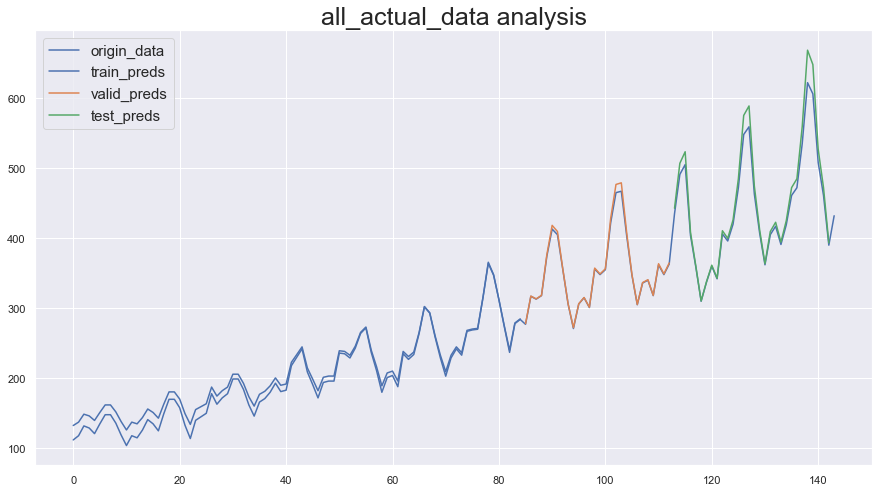

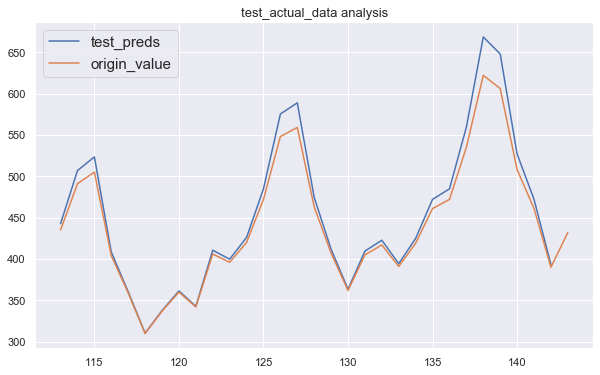

In [266]:
inverse_train_preds = scaler.inverse_transform(train_preds)
inverse_valid_preds = scaler.inverse_transform(valid_preds)
inverse_test_preds = scaler.inverse_transform(test_preds)


plt.figure(figsize=(15,8))
plt.plot(data.values[:,1],label='origin_data')
plt.plot([x for x in inverse_train_preds], c='b', label='train_preds')
plt.plot([None for _ in train_preds]+[x for x in inverse_valid_preds], label='valid_preds')
plt.plot([None for _ in train_preds]+[None for _ in valid_preds]+[x for x in inverse_test_preds], label='test_preds')
plt.title('all_actual_data analysis',fontsize=25)
plt.legend(fontsize=15)
plt.show()

plt.figure(figsize=(10,6))
plt.plot([None for _ in train_preds]+[None for _ in valid_preds]+[x for x in inverse_test_preds], label='test_preds')
plt.plot([None for _ in train_preds]+[None for _ in valid_preds]+[x for x in data.values[train_days+valid_days:,-1]], label='origin_value')
plt.legend(fontsize=15)
plt.title('test_actual_data analysis',fontsize=13)
plt.show()